In [1]:
from collections import defaultdict
import numpy as np
import os
import pandas as pd
from pprint import pprint
from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.callbacks import Callback
from keras.models import Model, Sequential
from keras.layers import (
    Activation, 
    Dense, 
    Embedding, 
    Input,
    Flatten
)
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from bilm.training import load_vocab

print(tf.__version__)

Using TensorFlow backend.


1.2.0


In [2]:
def reset_graph(seed=2018):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
def binarize_pos_neg(score):
    if score >= 5.0:
        score = 1
    else:
        score = 0
    return score

In [4]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [5]:
pos_neg_data_pre = pd.read_csv('pos_neg_labeling_7scaled.tsv', delimiter='\t')
pos_neg_data_pre.rename(columns={'긍정/부정 척도': 'sentiment'}, inplace=True)

neutral_sentiment = pos_neg_data_pre[pos_neg_data_pre['sentiment'] == 4.0]
neutral_sentiment_idx = neutral_sentiment.index

pos_neg_data_pre_wo_neutral = pos_neg_data_pre.drop(neutral_sentiment_idx).reset_index(drop=True)
pos_neg_data_pre_wo_neutral.drop(['명확도', 'Emojiness'], axis=1, inplace=True)

pos_neg_data = pos_neg_data_pre_wo_neutral.copy()
pos_neg_data['sentiment'] = pos_neg_data['sentiment'].apply(binarize_pos_neg)

sentences = pos_neg_data['queries']
sentence_splitted = [sentence.split(' ') for sentence in sentences]

In [6]:
vocab_file = '/media/scatter/scatterdisk/sandbox_temp/data/kakaotalk_sol_unique_tokens.txt'
vocab = load_vocab(vocab_file, 50)

In [7]:
sentences_encoded = []

for sentence in sentence_splitted:
    sentence_encoded = []
    for word in sentence:
        sentence_encoded.append(vocab.word_to_id(word))
    sentences_encoded.append(sentence_encoded)

sentences_encoded[:10]

[[31, 35, 102, 105],
 [55, 986, 102, 308],
 [2, 191],
 [12, 105],
 [2, 71, 748, 179, 1808, 36],
 [27, 1574, 2, 2, 2],
 [1958],
 [55, 2, 2],
 [2, 191],
 [2]]

In [8]:
VOCAB_SIZE = 605918
EMBEDDING_DIM = 256

ROOT_PATH = '/media/scatter/scatterdisk/elmo_ckpt/'

# ckpt_file = os.path.join(ROOT_PATH, 'elmo_ckpt_0831_1233/model_batch4700.ckpt-4700')
# ckpt_file = os.path.join(ROOT_PATH, 'elmo_ckpt_0904_1132/model_batch9200.ckpt-9200')
ckpt_file = os.path.join(ROOT_PATH, 'elmo_ckpt_0904_1535/model_batch9400.ckpt-9400')

w = tf.Variable(tf.constant(0.0, shape=[VOCAB_SIZE, EMBEDDING_DIM]),
                trainable=False, name='W')
# sentences_placeholder = tf.placeholder(tf.int32, shape=[None, None])
words_placeholder = tf.placeholder(tf.int32, shape=[None])

# config = tf.ConfigProto(allow_soft_placement=True)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

embedding_saver = tf.train.Saver({'lm/softmax/W': w})
embedding_saver.restore(sess, ckpt_file)
embedding_lookup = tf.nn.embedding_lookup(w, words_placeholder)

INFO:tensorflow:Restoring parameters from /media/scatter/scatterdisk/elmo_ckpt/elmo_ckpt_0904_1535/model_batch9400.ckpt-9400


In [9]:
word_index = {}

for sentence in sentences:
    for word in sentence.split(' '):
        if word not in word_index:
            word_index[word] = len(word_index)

print(len(word_index))

2886


In [10]:
embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    embed = sess.run(embedding_lookup, feed_dict={words_placeholder: [vocab.word_to_id(word)]})
    embedding_matrix[i] = embed

In [11]:
MAX_SEQUENCE_LENGTH = max(len(sentence_encoded) 
                          for sentence_encoded in sentences_encoded)
MAX_SEQUENCE_LENGTH

9

In [12]:
labels = np.asarray(pos_neg_data['sentiment'])
labels = np_utils.to_categorical(labels)

In [13]:
VALIDATION_SPLIT = 0.1

data = pad_sequences(sentences_encoded, maxlen=MAX_SEQUENCE_LENGTH)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [14]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1)

In [15]:
x_train.shape, x_val.shape, x_test.shape

((1296, 9), (160, 9), (145, 9))

In [16]:
reset_graph()

embedding_layer = Embedding(len(word_index)+1, 
                            256, 
                            weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, 
                            trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 9, 256)            739072    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4610      
Total params: 743,682
Trainable params: 4,610
Non-trainable params: 739,072
_________________________________________________________________
None


In [18]:
class_weight = {0: 0.1, 1: 0.9}

history = model.fit(x_train, y_train, 
                    epochs=20, 
                    validation_data=(x_val, y_val),
#                     class_weight='auto',
                    class_weight=class_weight,
                    callbacks=[TestCallback((x_test, y_test))])

Train on 1296 samples, validate on 160 samples
Epoch 1/20
 672/1296 [==============>...............] - ETA: 0s - loss: 0.5131 - acc: 0.8497
Testing loss: 0.3812925145543855, acc: 0.8758620697876502

1296/1296 [==============================] - 0s - loss: 0.4668 - acc: 0.8557 - val_loss: 0.3405 - val_acc: 0.9062
Epoch 2/20
 736/1296 [================>.............] - ETA: 0s - loss: 0.3968 - acc: 0.8641
Testing loss: 0.370234712650036, acc: 0.8758620697876502

1296/1296 [==============================] - 0s - loss: 0.4042 - acc: 0.8611 - val_loss: 0.3228 - val_acc: 0.9062
Epoch 3/20
 960/1296 [=====================>........] - ETA: 0s - loss: 0.3989 - acc: 0.8646
Testing loss: 0.36869780482917, acc: 0.8758620697876502

1296/1296 [==============================] - 0s - loss: 0.4018 - acc: 0.8611 - val_loss: 0.3194 - val_acc: 0.9062
Epoch 4/20
1056/1296 [=======================>......] - ETA: 0s - loss: 0.4113 - acc: 0.8561
Testing loss: 0.3682291117207757, acc: 0.8758620697876502

1296/1

In [19]:
model.evaluate(x_test, y_test)

 32/145 [=====>........................] - ETA: 0s

[0.3684779426147198, 0.8758620697876502]

In [20]:
import matplotlib.pyplot as plt


def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc=0)


def plot_acc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc=0)

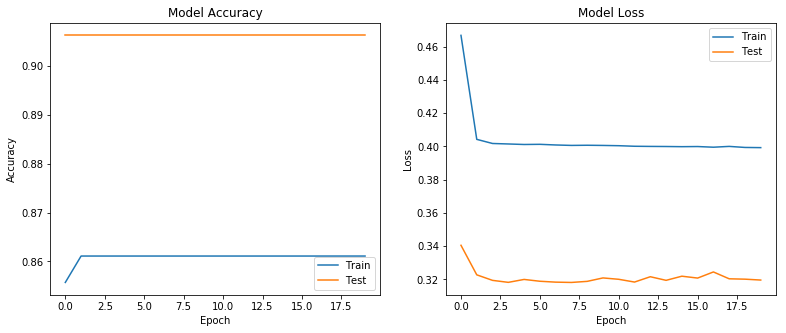

In [21]:
plt.figure(figsize=(13,5))
plt.subplot(121)
plot_acc(history)
plt.subplot(122)
plot_loss(history)